In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects
from matplotlib.colors import BoundaryNorm

import numpy as np

import xarray as xr

import netCDF4
from netCDF4 import Dataset, num2date

import metpy 
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from metpy.units import units

from datetime import datetime, timedelta
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import glob

from wrf import to_np, getvar, CoordPair, vertcross, interpline

import math

%config InlineBackend.figure_format='retina'

plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2

In [2]:
def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d

In [3]:
#Inital Variables Needed for File Read In 
rf = 'RF08'
rf2=8

if rf == 'RF01':
    iop_t =  [['2017-01-08 02:45:11', '2017-01-08 02:56:13', '1', 0],
              ['2017-01-08 03:00:04', '2017-01-08 03:16:16', '2', 1],
              ['2017-01-08 03:20:02', '2017-01-08 03:27:36', '3', 0],
              ['2017-01-08 03:31:01', '2017-01-08 03:50:56', '4', 1],
              ['2017-01-08 03:54:14', '2017-01-08 04:05:13', '5', 0],
              ['2017-01-08 04:07:33', '2017-01-08 04:29:13', '6', 1],
              ['2017-01-08 04:31:48', '2017-01-08 04:43:01', '7', 0],
              ['2017-01-08 04:45:36', '2017-01-08 05:06:50', '8', 1],
              ['2017-01-08 05:09:18', '2017-01-08 05:21:00', '9', 0],
              ['2017-01-08 05:23:06', '2017-01-08 05:40:08', '10', 1]]

if rf == 'RF02':
    iop_t = [['2017-01-09 04:38:24', '2017-01-09 04:46:01', '1', 0], #going north east
             ['2017-01-09 04:50:13', '2017-01-09 05:06:07', '2', 1], #going south west
             ['2017-01-09 05:09:57', '2017-01-09 05:17:24', '3', 0],
             ['2017-01-09 05:21:10', '2017-01-09 05:38:02', '4', 1],
             ['2017-01-09 05:42:35', '2017-01-09 05:50:27', '5', 0],
             ['2017-01-09 05:54:28', '2017-01-09 06:13:55', '6', 1],
             ['2017-01-09 06:18:18', '2017-01-09 06:28:08', '7', 0],
             ['2017-01-09 06:32:49', '2017-01-09 06:50:20', '8', 1],
             ['2017-01-09 06:54:36', '2017-01-09 07:04:51', '9',0],
             ['2017-01-09 07:09:18', '2017-01-09 07:26:38','10',1]]

if rf == 'RF03':
    iop_t = [['2017-01-11 02:48:36', '2017-01-11 03:03:39', '1', 0],
             ['2017-01-11 03:06:36', '2017-01-11 03:24:18', '2', 1],
             ['2017-01-11 03:27:18', '2017-01-11 03:34:15', '3', 0],
             ['2017-01-11 03:37:30', '2017-01-11 03:51:43', '4', 1],
             ['2017-01-11 03:55:12', '2017-01-11 04:02:52', '5', 0],
             ['2017-01-11 04:06:36', '2017-01-11 04:21:11', '6', 1],
             ['2017-01-11 04:24:50', '2017-01-11 04:35:35', '7', 0],
             ['2017-01-11 04:39:36', '2017-01-11 04:58:23', '8', 1],
             ['2017-01-11 05:01:48', '2017-01-11 05:12:54', '9', 0],
             ['2017-01-11 05:16:48', '2017-01-11 05:28:12','10', 1]]

if rf == 'RF04':
    iop_t = [['2017-01-18 20:16:12', '2017-01-18 20:31:19', '1', 0],
             ['2017-01-18 20:34:23', '2017-01-18 20:50:20', '2', 1],
             ['2017-01-18 20:54:18', '2017-01-18 21:05:02', '3', 0],
             ['2017-01-18 21:07:37', '2017-01-18 21:24:32', '4', 1],
             ['2017-01-18 21:27:54', '2017-01-18 21:38:17', '5', 0],
             ['2017-01-18 21:41:42', '2017-01-18 21:57:32', '6', 1],
             ['2017-01-18 22:00:18', '2017-01-18 22:11:42', '7', 0],
             ['2017-01-18 22:14:24', '2017-01-18 22:30:29', '8', 1],
             ['2017-01-18 22:33:36', '2017-01-18 22:43:37', '9', 0],
             ['2017-01-18 22:46:12', '2017-01-18 23:01:00','10', 1]]

if rf == 'RF05':
    iop_t =[['2017-01-19 15:40:48', '2017-01-19 15:59:17', '1', 0],
            ['2017-01-19 16:02:42', '2017-01-19 16:19:44', '2', 1],
            ['2017-01-19 16:22:48', '2017-01-19 16:36:18', '3', 0],
            ['2017-01-19 16:39:54', '2017-01-19 16:53:38', '4', 1],
            ['2017-01-19 16:55:55', '2017-01-19 17:07:48', '5', 0],
            ['2017-01-19 17:10:30', '2017-01-19 17:23:02', '6', 1],
            ['2017-01-19 17:25:30', '2017-01-19 17:34:44', '7', 0],
            ['2017-01-19 17:37:55', '2017-01-19 17:49:37', '8', 1],
            ['2017-01-19 17:52:01', '2017-01-19 18:01:08', '9', 0],
            ['2017-01-19 18:03:36', '2017-01-19 18:31:50', '10', 1]]

if rf == 'RF06':
    iop_t =[['2017-01-19 22:45:54', '2017-01-19 23:05:02', '1', 0],
            ['2017-01-19 23:08:06', '2017-01-19 23:25:12', '2', 1],
            ['2017-01-19 23:29:24', '2017-01-19 23:43:08', '3', 0],
            ['2017-01-19 23:45:57', '2017-01-20 00:02:27', '4', 1],
            ['2017-01-20 00:06:36', '2017-01-20 00:19:40', '5', 0],
            ['2017-01-20 00:22:40', '2017-01-20 00:39:07', '6', 1],
            ['2017-01-20 00:42:36', '2017-01-20 00:57:14', '7', 0],
            ['2017-01-20 00:59:42', '2017-01-20 01:17:24', '8', 1],
            ['2017-01-20 01:21:36', '2017-01-20 01:36:00', '9', 0],
            ['2017-01-20 01:39:00', '2017-01-20 01:52:08', '10', 1]]

if rf == 'RF07':
    iop_t =[['2017-01-21 22:49:37', '2017-01-21 22:57:39', '1', 0],
            ['2017-01-21 23:00:25', '2017-01-21 23:10:30', '2', 1],
            ['2017-01-21 23:13:04', '2017-01-21 23:20:49', '3', 0],
            ['2017-01-21 23:33:25', '2017-01-21 23:41:31', '4', 1],
            ['2017-01-21 23:44:42', '2017-01-21 23:52:01', '5', 0],
            ['2017-01-21 23:55:08', '2017-01-22 00:03:39', '6', 1],
            ['2017-01-22 00:06:32', '2017-01-22 00:14:20', '7', 0],
            ['2017-01-22 00:17:06', '2017-01-22 00:25:40', '8', 1],
            ['2017-01-22 00:28:12', '2017-01-22 00:36:46', '9', 0],
            ['2017-01-22 00:39:36', '2017-01-22 00:48:18', '10', 1],
            ['2017-01-22 00:51:14', '2017-01-22 00:59:38', '11', 0],
            ['2017-01-22 01:02:24', '2017-01-22 01:10:40', '12', 1],
            ['2017-01-22 01:15:50', '2017-01-22 01:28:48', '13', 1]]

if rf == 'RF08':
    iop_t =[['2017-01-22 21:11:13', '2017-01-22 21:23:02', '1', 0],
            ['2017-01-22 21:25:44', '2017-01-22 21:40:55', '2', 1],
            ['2017-01-22 21:43:37', '2017-01-22 21:50:45', '3', 0],
            ['2017-01-22 21:53:16', '2017-01-22 22:05:38', '4', 1],
            ['2017-01-22 22:08:24', '2017-01-22 22:18:10', '5', 0],
            ['2017-01-22 22:20:31', '2017-01-22 22:38:09', '6', 1],
            ['2017-01-22 22:40:30', '2017-01-22 22:52:19', '7', 0],
            ['2017-01-22 22:54:43', '2017-01-22 23:12:36', '8', 1],
            ['2017-01-22 23:15:28', '2017-01-22 23:26:27', '9', 0],
            ['2017-01-22 23:29:24', '2017-01-22 23:46:15','10', 1],
            ['2017-01-22 23:49:30', '2017-01-23 00:00:32','11', 0],
            ['2017-01-23 00:03:00', '2017-01-23 00:20:24','12', 1]]

if rf == 'RF09':
    iop_t =[['2017-01-31 20:21:00', '2017-01-31 20:31:08', '1', 0],
            ['2017-01-31 20:34:51', '2017-01-31 20:52:26', '2', 1],
            ['2017-01-31 21:00:54', '2017-01-31 21:06:07', '3', 0],
            ['2017-01-31 21:08:42', '2017-01-31 21:12:46', '4', 1],
            ['2017-01-31 21:15:36', '2017-01-31 21:19:49', '5', 0],
            ['2017-01-31 21:22:22', '2017-01-31 21:28:30', '6', 1],
            ['2017-01-31 21:31:12', '2017-01-31 21:38:38', '7', 0], 
            ['2017-01-31 21:48:00', '2017-01-31 22:01:19', '8', 1]]

if rf == 'RF10':
    iop_t = [['2017-02-03 20:06:25', '2017-02-03 20:17:49', '1', 0],
             ['2017-02-03 20:20:42', '2017-02-03 20:38:02', '2', 1],
             ['2017-02-03 20:40:30', '2017-02-03 20:50:06', '3', 0],
             ['2017-02-03 20:53:00', '2017-02-03 21:03:43', '4', 1],
             ['2017-02-03 21:06:18', '2017-02-03 21:13:22', '5', 0],
             ['2017-02-03 21:16:48', '2017-02-03 21:27:00', '6', 1]]

if rf == 'RF11':
    iop_t =[['2017-02-04 22:08:34', '2017-02-04 22:17:56', '1', 0],
            ['2017-02-04 22:21:00', '2017-02-04 22:38:45', '2', 1],
            ['2017-02-04 22:42:00', '2017-02-04 22:52:33', '3', 0],
            ['2017-02-04 22:55:48', '2017-02-04 23:11:31', '4', 1],
            ['2017-02-04 23:14:42', '2017-02-04 23:27:00', '5', 0],
            ['2017-02-04 23:29:24', '2017-02-04 23:43:10', '6', 1],
            ['2017-02-04 23:45:54', '2017-02-04 23:56:38', '7', 0],
            ['2017-02-04 23:59:24', '2017-02-05 00:12:18', '8', 1],
            ['2017-02-05 00:15:00', '2017-02-05 00:25:40', '9', 0],
            ['2017-02-05 00:28:01', '2017-02-05 00:42:25', '10', 1],
            ['2017-02-05 00:45:00', '2017-02-05 00:56:09', '11', 0],
            ['2017-02-05 00:59:24', '2017-02-05 01:07:38', '12', 1]]

if rf == 'RF12':
    iop_t =[['2017-02-07 20:13:40', '2017-02-07 20:23:35', '1', 0],
            ['2017-02-07 20:26:30', '2017-02-07 20:46:05', '2', 1],
            ['2017-02-07 20:50:00', '2017-02-07 20:59:30', '3', 0],
            ['2017-02-07 21:02:40', '2017-02-07 21:22:25', '4', 1],
            ['2017-02-07 21:25:10', '2017-02-07 21:35:00', '5', 0],
            ['2017-02-07 21:37:10', '2017-02-07 21:56:50', '6', 1],
            ['2017-02-07 21:59:40', '2017-02-07 22:09:35', '7', 0],
            ['2017-02-07 22:12:50', '2017-02-07 22:33:50', '8', 1],
            ['2017-02-07 22:37:00', '2017-02-07 22:46:10', '9', 0],
            ['2017-02-07 22:49:00', '2017-02-07 23:03:00','10', 1]]

if rf == 'RF13':
    iop_t = [['2017-02-16 23:42:53', '2017-02-16 23:53:16', '1', 0],
             ['2017-02-16 23:57:00', '2017-02-17 00:13:12', '2', 1],
             ['2017-02-17 00:15:36', '2017-02-17 00:25:48', '3', 0],
             ['2017-02-17 00:27:36', '2017-02-17 00:43:48', '4', 1]]

if rf == 'RF14':
    iop_t = [['2017-02-18 21:39:39', '2017-02-18 21:57:57', '1', 0],
             ['2017-02-18 22:00:50', '2017-02-18 22:21:39', '2', 1],
             ['2017-02-18 22:24:00', '2017-02-18 22:37:26', '3', 0],
             ['2017-02-18 22:39:00', '2017-02-18 22:58:08', '4', 1],
             ['2017-02-18 23:00:39', '2017-02-18 23:14:24', '5', 0],
             ['2017-02-18 23:16:12', '2017-02-18 23:34:40', '6', 1],
             ['2017-02-18 23:36:21', '2017-02-18 23:50:42', '7', 0],
             ['2017-02-18 23:52:26', '2017-02-19 00:07:01', '8', 1],
             ['2017-02-19 00:09:00', '2017-02-19 00:19:51', '9', 0],
             ['2017-02-19 00:21:36', '2017-02-19 00:41:24', '10', 1]]

if rf == 'RF15':
    iop_t = [['2017-02-19 17:44:06', '2017-02-19 17:55:12', '1', 0],
             ['2017-02-19 17:57:28', '2017-02-19 18:15:18', '2', 1],
             ['2017-02-19 18:17:52', '2017-02-19 18:30:50', '3', 0],
             ['2017-02-19 18:33:10', '2017-02-19 18:46:15', '4', 1],
             ['2017-02-19 18:49:30', '2017-02-19 18:58:37', '5', 0],
             ['2017-02-19 19:01:58', '2017-02-19 19:09:50', '6', 1],
             ['2017-02-19 19:13:01', '2017-02-19 19:18:57', '7', 0],
             ['2017-02-19 19:21:32', '2017-02-19 19:39:07', '8', 1],
             ['2017-02-19 19:42:00', '2017-02-19 19:57:36', '9', 0],
             ['2017-02-19 20:00:18', '2017-02-19 20:14:31', '10', 1],
             ['2017-02-19 20:17:34', '2017-02-19 20:26:56', '11', 0],
             ['2017-02-19 20:30:07', '2017-02-19 20:46:00', '12', 1]]

if rf == 'RF16':
    iop_t =[['2017-02-20 14:46:55', '2017-02-20 14:57:25', '1', 0],
            ['2017-02-20 15:00:54', '2017-02-20 15:20:56', '2', 1],
            ['2017-02-20 15:24:36', '2017-02-20 15:35:45', '3', 0],
            ['2017-02-20 15:38:42', '2017-02-20 15:58:40', '4', 1],
            ['2017-02-20 16:01:48', '2017-02-20 16:12:46', '5', 0],
            ['2017-02-20 16:16:20', '2017-02-20 16:37:44', '6', 1],
            ['2017-02-20 16:40:40', '2017-02-20 16:48:43', '7', 0],
            ['2017-02-20 17:03:00', '2017-02-20 17:25:26', '8', 1]]

if rf == 'RF17':
    iop_t =[['2017-02-21 14:42:00', '2017-02-21 14:52:30', '1', 0],
            ['2017-02-21 14:55:51', '2017-02-21 15:15:50', '2', 1],
            ['2017-02-21 15:19:37', '2017-02-21 15:30:36', '3', 0],
            ['2017-02-21 15:34:12', '2017-02-21 15:53:27', '4', 1],
            ['2017-02-21 16:17:49', '2017-02-21 16:31:12', '5', 0],
            ['2017-02-21 16:35:06', '2017-02-21 16:52:40', '6', 1],
            ['2017-02-21 16:55:30', '2017-02-21 17:06:25', '7', 0],
            ['2017-02-21 17:09:36', '2017-02-21 17:30:21', '8', 1],
            ['2017-02-21 17:33:14', '2017-02-21 17:44:13', '9', 0],
            ['2017-02-21 17:47:42', '2017-02-21 18:06:50','10', 1]]

if rf == 'RF19':
    iop_t =[['2017-03-04 13:29:24', '2017-03-04 13:39:50', '1', 0],
            ['2017-03-04 13:43:19', '2017-03-04 14:00:10', '2', 1],
            ['2017-03-04 14:03:14', '2017-03-04 14:15:10', '3', 0],
            ['2017-03-04 14:18:25', '2017-03-04 14:33:43', '4', 1],
            ['2017-03-04 14:38:07', '2017-03-04 14:48:36', '5', 0],
            ['2017-03-04 14:51:21', '2017-03-04 15:01:48', '6', 1],
            ['2017-03-04 15:04:12', '2017-03-04 15:12:43', '7', 0],
            ['2017-03-04 15:14:13', '2017-03-04 15:24:28', '8', 1],
            ['2017-03-04 15:27:00', '2017-03-04 15:34:48', '9', 0],
            ['2017-03-04 15:37:48', '2017-03-04 15:47:09', '10', 1],
            ['2017-03-04 15:50:09', '2017-03-04 15:58:01', '11', 0],
            ['2017-03-04 16:00:14', '2017-03-04 16:07:04', '12', 1],
            ['2017-03-04 16:09:36', '2017-03-04 16:18:57', '13', 0],
            ['2017-03-04 16:21:28', '2017-03-04 16:42:43', '14', 1]]

if rf == 'RF20':
    iop_t =[['2017-03-05 12:11:52', '2017-03-05 12:22:37', '1', 0],
            ['2017-03-05 12:26:24', '2017-03-05 12:44:24', '2', 1],
            ['2017-03-05 12:47:42', '2017-03-05 12:59:38', '3', 0],
            ['2017-03-05 13:02:09', '2017-03-05 13:16:58', '4', 1],
            ['2017-03-05 13:20:06', '2017-03-05 13:29:24', '5', 0],
            ['2017-03-05 13:32:24', '2017-03-05 13:46:51', '6', 1],
            ['2017-03-05 13:49:30', '2017-03-05 13:58:58', '7', 0],
            ['2017-03-05 14:02:34', '2017-03-05 14:17:09', '8', 1],
            ['2017-03-05 14:20:42', '2017-03-05 14:30:18', '9', 0],
            ['2017-03-05 14:33:36', '2017-03-05 14:51:54', '10', 1]]

if rf == 'RF21':
    iop_t =[['2017-03-07 14:22:12', '2017-03-07 14:33:14', '1', 0],
            ['2017-03-07 14:36:18', '2017-03-07 14:51:39', '2', 1],
            ['2017-03-07 14:54:36', '2017-03-07 15:07:40', '3', 0],
            ['2017-03-07 15:09:00', '2017-03-07 15:23:56', '4', 1],
            ['2017-03-07 15:26:24', '2017-03-07 15:38:24', '5', 0],
            ['2017-03-07 15:39:43', '2017-03-07 15:55:37', '6', 1],
            ['2017-03-07 15:58:24', '2017-03-07 16:10:48', '7', 0],
            ['2017-03-07 16:12:18', '2017-03-07 16:27:54', '8', 1],
            ['2017-03-07 16:30:36', '2017-03-07 16:42:57', '9', 0],
            ['2017-03-07 16:45:00', '2017-03-07 16:58:58', '10', 1],
            ['2017-03-07 17:01:22', '2017-03-07 17:11:16', '11', 0],
            ['2017-03-07 17:12:25', '2017-03-07 17:16:30', '12', 1],
            ['2017-03-07 17:18:10', '2017-03-07 17:23:06', '13', 0],
            ['2017-03-07 17:24:18', '2017-03-07 17:38:08', '14', 1]]

if rf == 'RF22':
    iop_t =[['2017-03-09 14:22:30', '2017-03-09 14:32:15', '1', 0], #going east
            ['2017-03-09 14:35:05', '2017-03-09 14:54:55', '2', 1], #going west
            ['2017-03-09 14:58:35', '2017-03-09 15:09:30', '3', 0],
            ['2017-03-09 15:13:20', '2017-03-09 15:32:10', '4', 1],
            ['2017-03-09 15:35:40', '2017-03-09 15:46:30', '5', 0],
            ['2017-03-09 15:50:40', '2017-03-09 16:08:10', '6', 1],
            ['2017-03-09 16:11:35', '2017-03-09 16:22:55', '7', 0],
            ['2017-03-09 16:26:45', '2017-03-09 16:46:00', '8', 1]]

if rf == 'RF23':
       iop_t =[['2017-03-09 20:19:45', '2017-03-09 20:30:00', '1', 0],
            ['2017-03-09 20:34:00', '2017-03-09 20:40:30', '2', 1],
            ['2017-03-09 20:56:50', '2017-03-09 21:08:55', '3', 0],
            ['2017-03-09 21:12:54', '2017-03-09 21:23:09', '4', 1],
            ['2017-03-09 21:27:18', '2017-03-09 21:44:31', '5', 1],
            ['2017-03-09 21:47:42', '2017-03-09 21:58:48', '6', 0],
            ['2017-03-09 22:02:06', '2017-03-09 22:21:10', '7', 1],
            ['2017-03-09 22:24:00', '2017-03-09 22:35:42', '8', 0],
            ['2017-03-09 22:39:21', '2017-03-09 22:57:07', '9', 1],
            ['2017-03-09 22:59:42', '2017-03-09 23:11:31','10', 0],
            ['2017-03-09 23:14:12', '2017-03-09 23:32:31','11', 1]]

if rf == 'RF24':
    iop_t =[['2017-03-16 01:07:37', '2017-03-16 01:18:18', '1', 0],
            ['2017-03-16 01:21:18', '2017-03-16 01:40:40', '2', 1],
            ['2017-03-16 01:44:06', '2017-03-16 01:54:39', '3', 0],
            ['2017-03-16 01:57:54', '2017-03-16 02:15:25', '4', 1],
            ['2017-03-16 02:18:21', '2017-03-16 02:30:14', '5', 0],
            ['2017-03-16 02:33:36', '2017-03-16 02:51:21', '6', 1],
            ['2017-03-16 02:54:07', '2017-03-16 03:06:14', '7', 0],
            ['2017-03-16 03:08:56', '2017-03-16 03:26:55', '8', 1],
            ['2017-03-16 03:30:07', '2017-03-16 03:41:55', '9', 0],
            ['2017-03-16 03:45:00', '2017-03-16 04:02:24', '10', 1],
            ['2017-03-16 04:04:48', '2017-03-16 04:09:32', '11', 0],
            ['2017-03-16 04:11:56', '2017-03-16 04:20:27', '12', 1]]

In [4]:
#choosing the index in iop_t
timeidx = 3
#info on that leg
leg= iop_t[timeidx][2]
start_time = iop_t[timeidx][0]
end_time = iop_t[timeidx][1]
print(iop_t[timeidx][3])
print(leg)

1
4


In [5]:
start_time

'2017-01-22 21:53:16'

In [6]:
#bringing in distance of the flight leg

#Reading in the Flight Level Data
fld = Dataset('/glade/u/home/tzaremba/Data/Flight Level Data/'+rf+'.nc')
#fld = Dataset('/glade/scratch/kaylee/Data/Data-Flight_level/RF9.nc')

#reading in all variables needed
flight_lats = pd.DataFrame(fld['glat'][:]).mean(axis = 1)
flight_lons = pd.DataFrame(fld['glon'][:]).mean(axis = 1)
raw_angle= np.asarray(fld.variables['AVthead'][:])
flight_plane_alt= pd.DataFrame(fld['GALT'][:]).mean(axis = 1)
flight_topo = pd.DataFrame(fld['topo'][:]).mean(axis=1)

#making time into a format we can use
flight_time = netCDF4.num2date(fld['time'][:],units = fld['time'].units[:-6])
flight_time = pd.to_datetime(flight_time.astype(str))

#making a dataframe during the flight leg
flight_df = pd.DataFrame()
flight_df['Lats'] = flight_lats
flight_df['Lons'] = flight_lons
flight_df['plane_alt']= flight_plane_alt
flight_df['topo']= flight_topo


flight_df.index = flight_time
flight_leg = flight_df.between_time(start_time[11:], end_time[11:])

#calculating the distance between points along the flight
distance = great_circle(flight_leg.Lats.values, flight_leg.Lons.values)
distance = np.cumsum(distance)
distance_km= distance/1000

#making distance into a dataframe
df_distance = pd.DataFrame(distance)

#making a time dataframe
df_flight_time=pd.DataFrame(flight_time)
df_flight_time.index=flight_time
df_flight_time_subset= df_flight_time.between_time(start_time[11:], end_time[11:])
df_flight_time_subset=np.asarray(df_flight_time_subset)

#calculating the angle needed (90-the angle from y axis to flight track) and putting it into a datframe for the flight leg
wanted_angle=np.zeros(raw_angle.shape[0])
for n in range(raw_angle.shape[0]):
    wanted_angle[n]=math.radians((90)-raw_angle[n])
df_a=pd.DataFrame(wanted_angle)
df_a.index=flight_time
df_a_subset= df_a.between_time(start_time[11:], end_time[11:])

a_subset=np.asarray(df_a_subset)

In [7]:
#Reading in the WRF Data
file_list_wrf = glob.glob('/glade/scratch/kyoko/IDAHO/lulin_d2_900m/wrfout/*')
file_list_wrf = sorted(file_list_wrf)

list_of_file_dates = []
list_of_file_datetimes = []

for i in range(len(file_list_wrf)):
    list_of_file_dates.append(file_list_wrf[i][-19:].replace('_', ' '))
    list_of_file_datetimes.append(datetime.strptime(file_list_wrf[i][-19:].replace('_', ' '), "%Y-%m-%d %H:%M:%S"))


#This is where I started changing things, the commented section is your old code

#d1 = datetime.strptime(startT_fl_east,"%Y-%m-%d %H:%M:%S")
#d2 = datetime.strptime(endT_fl_west,"%Y-%m-%d %H:%M:%S")
#half_way_between_fl = str(d1 + (d2 - d1))
d1 = datetime.strptime(start_time,"%Y-%m-%d %H:%M:%S")
d2 = datetime.strptime(end_time,"%Y-%m-%d %H:%M:%S")
half_way_between_fl = str((d2 - d1)+d1)

time_difference = []
for i in range(len(list_of_file_datetimes)):
    time_difference.append(abs(list_of_file_datetimes[i] - (d1 + (d2 - d1))))
file_index_closest_time = np.argmin(time_difference)

#time_difference = []
#for i in range(len(list_of_file_datetimes)):
    #time_difference.append(abs(list_of_file_datetimes[i] - (d1 + (d2 - d1))))

#file_index_closest_time = np.argmin(time_difference)

wrf_file_wanted = file_list_wrf[file_index_closest_time]
wrf_time=str(wrf_file_wanted)
wrf_read_in = Dataset(wrf_file_wanted)

#Reading in variables we want to look at 
z = getvar(wrf_read_in, "z")
wspd =  getvar(wrf_read_in, "uvmet_wspd_wdir", units="kt")[0,:]
w = getvar(wrf_read_in, "W")[1:, :, :]
terrain=getvar(wrf_read_in, "HGT")

# Create the start point and end points for each cross section
#East
start_point = CoordPair(lat=flight_leg.Lats.values[0], lon=flight_leg.Lons.values[0])
end_point = CoordPair(lat=flight_leg.Lats.values[-1], lon=flight_leg.Lons.values[-1])


# Compute the vertical cross-section interpolation.  Also want to include the lat/lon points along the cross-section.
#East
z_cross = vertcross(w, z, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True, autolevels=1000)
terr_cross= interpline(terrain, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True)
coord_pairs = to_np(z_cross.coords["xy_loc"])
coord_pairs_t= to_np(terr_cross.coords["xy_loc"])

#Setting up x and y axes
height = pd.concat([pd.DataFrame(z_cross.coords["vertical"].values)] * coord_pairs.shape[0], axis = 1, ignore_index = True)
across = pd.concat([pd.DataFrame(np.arange(height.shape[1]))] * height.shape[0], axis = 1, ignore_index = True)

wrf_height_a=np.asarray(height)
wrf_height_calcs= wrf_height_a.T

wrf_w_a=np.asarray(z_cross)

#finding distance of the Lat, lon pairs
lats_wrf = []
lons_wrf = []

for i in range(coord_pairs.shape[0]):
    lats_wrf.append(coord_pairs[i].lat)
    lons_wrf.append(coord_pairs[i].lon)

wrf_lat_lons = pd.DataFrame()
wrf_lat_lons['lats'] = lats_wrf
wrf_lat_lons['lons'] = lons_wrf

part1=great_circle(wrf_lat_lons['lats'].values, wrf_lat_lons['lons'].values)
wrf_distance=np.cumsum(part1)

In [8]:
print(start_time)
print(end_time)
print(wrf_file_wanted)

2017-01-22 21:53:16
2017-01-22 22:05:38
/glade/scratch/kyoko/IDAHO/lulin_d2_900m/wrfout/wrfout_d02_2017-01-22_22:00:00


In [9]:
new_w=pd.DataFrame(to_np(z_cross))
new_w.index=height.iloc[:,0]
w_3km=new_w.iloc[np.where(new_w.index.values<=4000)[0]]

w_3km=w_3km.T
#if iop_t[timeidx][3]==1:
    #w_3km=w_3km[::-1]
#if iop_t[timeidx][3]==0:
    #w_3km=w_3km
w_3km

,0.000000,20.226637,40.453274,60.679909,80.906548,101.133186,121.359818,141.586456,161.813095,182.039734,...,3802.607666,3822.834229,3843.061035,3863.287598,3883.514160,3903.740967,3923.967529,3944.194092,3964.420898,3984.647461
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.951240,0.968875,0.986509,1.004144,1.020674,1.036088,1.051501,1.066914,1.082046,1.094062
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.646059,0.661924,0.677792,0.693659,0.709527,0.725395,0.740816,0.755577,0.770338,0.785099
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393219,0.413549,0.433880,0.454448,0.475578,0.496708,0.517838,0.538968,0.559462,0.579871
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.374023,0.397912,0.421800,0.445689,0.469607,0.494168,0.518729,0.543290,0.567851,0.591397
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.485471,0.508798,0.532125,0.555452,0.578779,0.602018,0.625195,0.648373,0.671550,0.694269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.055584,0.061617,0.067650,0.073683,0.079134,0.084486,0.089837,0.095189,0.100311,0.104489
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.055277,-0.049136,-0.042995,-0.037374,-0.031855,-0.026337,-0.020818,-0.015697,-0.011158,-0.006618
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.133033,-0.129222,-0.125437,-0.121652,-0.117867,-0.114467,-0.111559,-0.108651,-0.105743,-0.102840
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.148847,-0.148474,-0.148101,-0.147729,-0.148099,-0.148578,-0.149058,-0.149538,-0.150306,-0.151427


In [10]:
if iop_t[timeidx][3]==0:
    terr_diff_org=pd.DataFrame(terr_cross).diff(periods=2, axis=0).shift(-1)
if iop_t[timeidx][3]==1:
    terr_diff_org=pd.DataFrame(terr_cross).iloc[::-1].diff(periods=2, axis=0).shift(-1)
terr_diff=terr_diff_org[1:-1]
terr_diff

,0
62,-144.571411
61,-119.697510
60,-130.002441
59,-161.692993
58,-151.608887
...,...
5,136.798706
4,34.073730
3,-37.612793
2,-60.542847


In [11]:
new_w_terr=w_3km.copy()
new_w_terr

,0.000000,20.226637,40.453274,60.679909,80.906548,101.133186,121.359818,141.586456,161.813095,182.039734,...,3802.607666,3822.834229,3843.061035,3863.287598,3883.514160,3903.740967,3923.967529,3944.194092,3964.420898,3984.647461
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.951240,0.968875,0.986509,1.004144,1.020674,1.036088,1.051501,1.066914,1.082046,1.094062
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.646059,0.661924,0.677792,0.693659,0.709527,0.725395,0.740816,0.755577,0.770338,0.785099
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393219,0.413549,0.433880,0.454448,0.475578,0.496708,0.517838,0.538968,0.559462,0.579871
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.374023,0.397912,0.421800,0.445689,0.469607,0.494168,0.518729,0.543290,0.567851,0.591397
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.485471,0.508798,0.532125,0.555452,0.578779,0.602018,0.625195,0.648373,0.671550,0.694269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.055584,0.061617,0.067650,0.073683,0.079134,0.084486,0.089837,0.095189,0.100311,0.104489
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.055277,-0.049136,-0.042995,-0.037374,-0.031855,-0.026337,-0.020818,-0.015697,-0.011158,-0.006618
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.133033,-0.129222,-0.125437,-0.121652,-0.117867,-0.114467,-0.111559,-0.108651,-0.105743,-0.102840
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.148847,-0.148474,-0.148101,-0.147729,-0.148099,-0.148578,-0.149058,-0.149538,-0.150306,-0.151427


In [12]:
tf=w_3km.isna()
jn, kn=np.where(tf==True)
j00,k00= np.where(w_3km==0)
j0,k0=np.where(w_3km<0)
j1,k1= np.where(w_3km>0)
nan_w_idx=np.asarray((list(zip(jn,kn))))
zer_w_idx=np.asarray((list(zip(j00,k00))))
neg_w_idx=np.asarray((list(zip(j0,k0))))
pos_w_idx=np.asarray((list(zip(j1,k1))))
for n in range(nan_w_idx.shape[0]):
    h,g=nan_w_idx[n,:]
    new_w_terr.iloc[h,g]=np.NaN
for n in range(zer_w_idx.shape[0]):
    h,g=zer_w_idx[n,:]
    new_w_terr.iloc[h,g]=np.NaN
for n in range(neg_w_idx.shape[0]):
    h,g=neg_w_idx[n,:]
    new_w_terr.iloc[h,g]=0
for n in range(pos_w_idx.shape[0]):
    h,g=pos_w_idx[n,:]
    new_w_terr.iloc[h,g]=1
    
if iop_t[timeidx][3]==0:
    w_01=new_w_terr.iloc[1:-1]
if iop_t[timeidx][3]==1:
    w_01=new_w_terr.iloc[::-1,:].iloc[1:-1]

In [13]:
len(nan_w_idx)+len(neg_w_idx)+len(pos_w_idx)+len(zer_w_idx)

12672

In [14]:
w_01

,0.000000,20.226637,40.453274,60.679909,80.906548,101.133186,121.359818,141.586456,161.813095,182.039734,...,3802.607666,3822.834229,3843.061035,3863.287598,3883.514160,3903.740967,3923.967529,3944.194092,3964.420898,3984.647461
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
terr_diff[terr_diff[0]==0]=np.NaN
terr_diff[terr_diff[0]<0]=0
terr_diff[terr_diff[0]>0]=1

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/pandas/core/frame.py:3063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer(indexer, value)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarni

In [16]:
terr_diff

,0
62,0.0
61,0.0
60,0.0
59,0.0
58,0.0
...,...
5,1.0
4,1.0
3,0.0
2,0.0


In [17]:
df=w_01.iloc[0]
print(terr_diff.values[0][0])
print(terr_cross.values[0])
print(int(len(np.where(df==0)[0])))
print(df.value_counts().sum())

0.0
1440.8157
131
131


In [18]:
percent=[]
matched=[]
total_count=[]
i=w_01.copy()
for n in range(terr_diff.shape[0]):
    df=w_01.iloc[n]
    if terr_diff.values[n][0]==0:
        j=n
        i_1=np.where(df==0)[0]
        i_0=np.where(df==1)[0]
        i.iloc[j,i_1]=1
        i.iloc[j,i_0]=0
        count0=int(len(np.where(df==0)[0]))
        totalcount=df.value_counts().sum()
        matched.append(count0)
        total_count.append(totalcount)
        percent.append((count0/totalcount)*100)
    if terr_diff.values[n][0]==1:
        k=n
        i_1=np.where(df==1)[0]
        i_0=np.where(df==0)[0]
        i.iloc[k,i_1]=1
        i.iloc[k,i_0]=0
        count1=len(np.where(df==1)[0])
        totalcount=df.value_counts().sum()
        matched.append(count1)
        total_count.append(totalcount)
        percent.append((count1/totalcount)*100)
    if terr_diff.values[n][0]!=1:
        if terr_diff.values[n][0]!=0:
            percent.append(np.NaN)
            matched.append(np.NaN)

In [19]:
matched_df=pd.DataFrame(matched).dropna()

total_pt=pd.DataFrame(total_count).values.sum()
total_matches=matched_df.values.sum()

total_percent=(total_matches/total_pt)*100

print(total_matches)
print(total_pt)
print(total_percent)

4616
7657
60.284706804231426


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'RF: 8, Leg: 4, Percent: 60.284706804231426')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


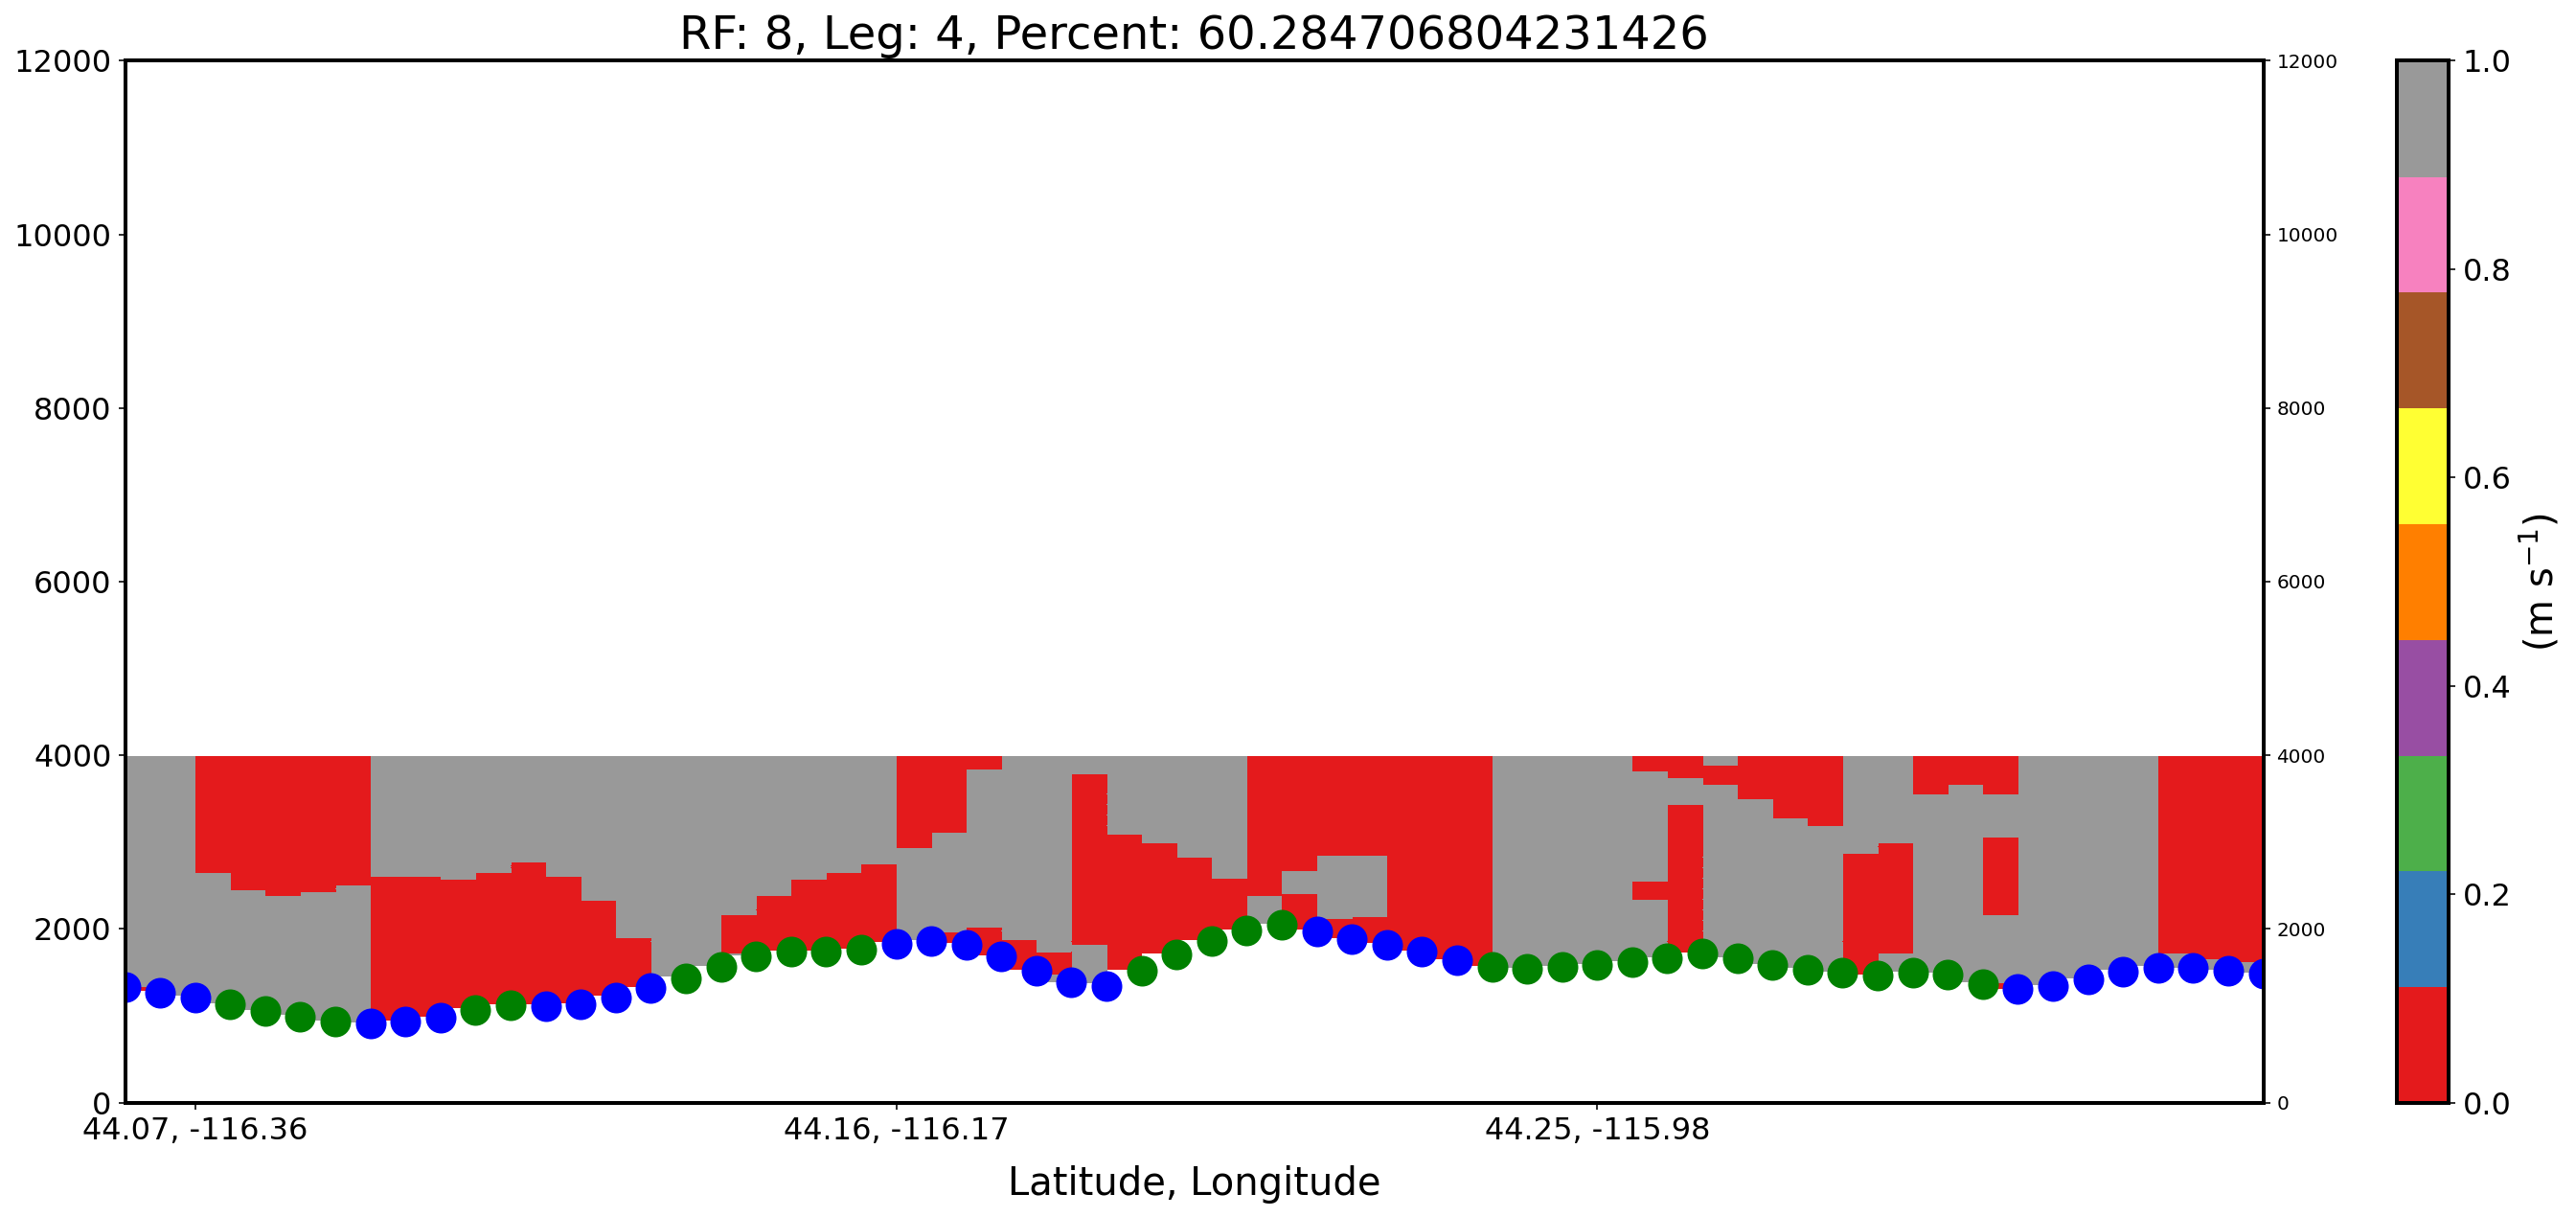

In [20]:
#setting up plot
fig, ax = plt.subplots(figsize = (25, 10))

#plotting w
if iop_t[timeidx][3]==0:
    cm = ax.pcolormesh(across.T.iloc[0:w_01.shape[1],1:-1], height.iloc[0:w_01.shape[1],1:-1], i.T.values, vmin = 0, vmax = 1, cmap = 'Set1')
if iop_t[timeidx][3]==1:
    cm = ax.pcolormesh(across.T.iloc[0:w_01.shape[1],1:-1], height.iloc[0:w_01.shape[1],1:-1], i[::-1].T.values, vmin = 0, vmax = 1, cmap = 'Set1')


#axis settings
ax.set_ylim(0, 12000)
coord_pairs = to_np(z_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}") for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])

#labels
ax.set_xticklabels(x_labels[::20], rotation=0)
ax.set_xlabel("Latitude, Longitude", fontsize=20, labelpad = 10)

#setting colorbar
cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)
ax.tick_params(which='both',labelsize=16)
    
ax2=ax.twinx()
ax2.set_ylim(0,12000)
for n in range(terr_cross[1:-1].shape[0]):
    if terr_diff.iloc[n].values[0]==1:
        #if iop_t[timeidx][3]==0:
        ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[1:-1].values[n], 'go', markersize=15)
        #if iop_t[timeidx][3]==1:
            #ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[::-1].iloc[1:-1].values[n], 'go', markersize=15)

    if terr_diff.iloc[n].values[0]==0:
        #if iop_t[timeidx][3]==0:
        ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[1:-1].values[n], 'bo', markersize=15)
        #if iop_t[timeidx][3]==1:
            #ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[::-1].iloc[1:-1].values[n], 'bo', markersize=15)

        
if iop_t[timeidx][3]==1:
    ax.invert_xaxis()



#ax2.set_xlim(min(wrf_distance), max(wrf_distance))
#test=ax2.plot(xcoord,ycoord, color='black')
plt.title('RF: {}, Leg: {}, Percent: {}'.format(rf2, leg, total_percent), fontsize=24)

#plt.savefig('/glade/u/home/kaylee/Quantifying_OF_T/I_plot_for_paper_WRF.pdf', format='pdf')

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'RF: 8, Leg: 4, Percent: 60.284706804231426')

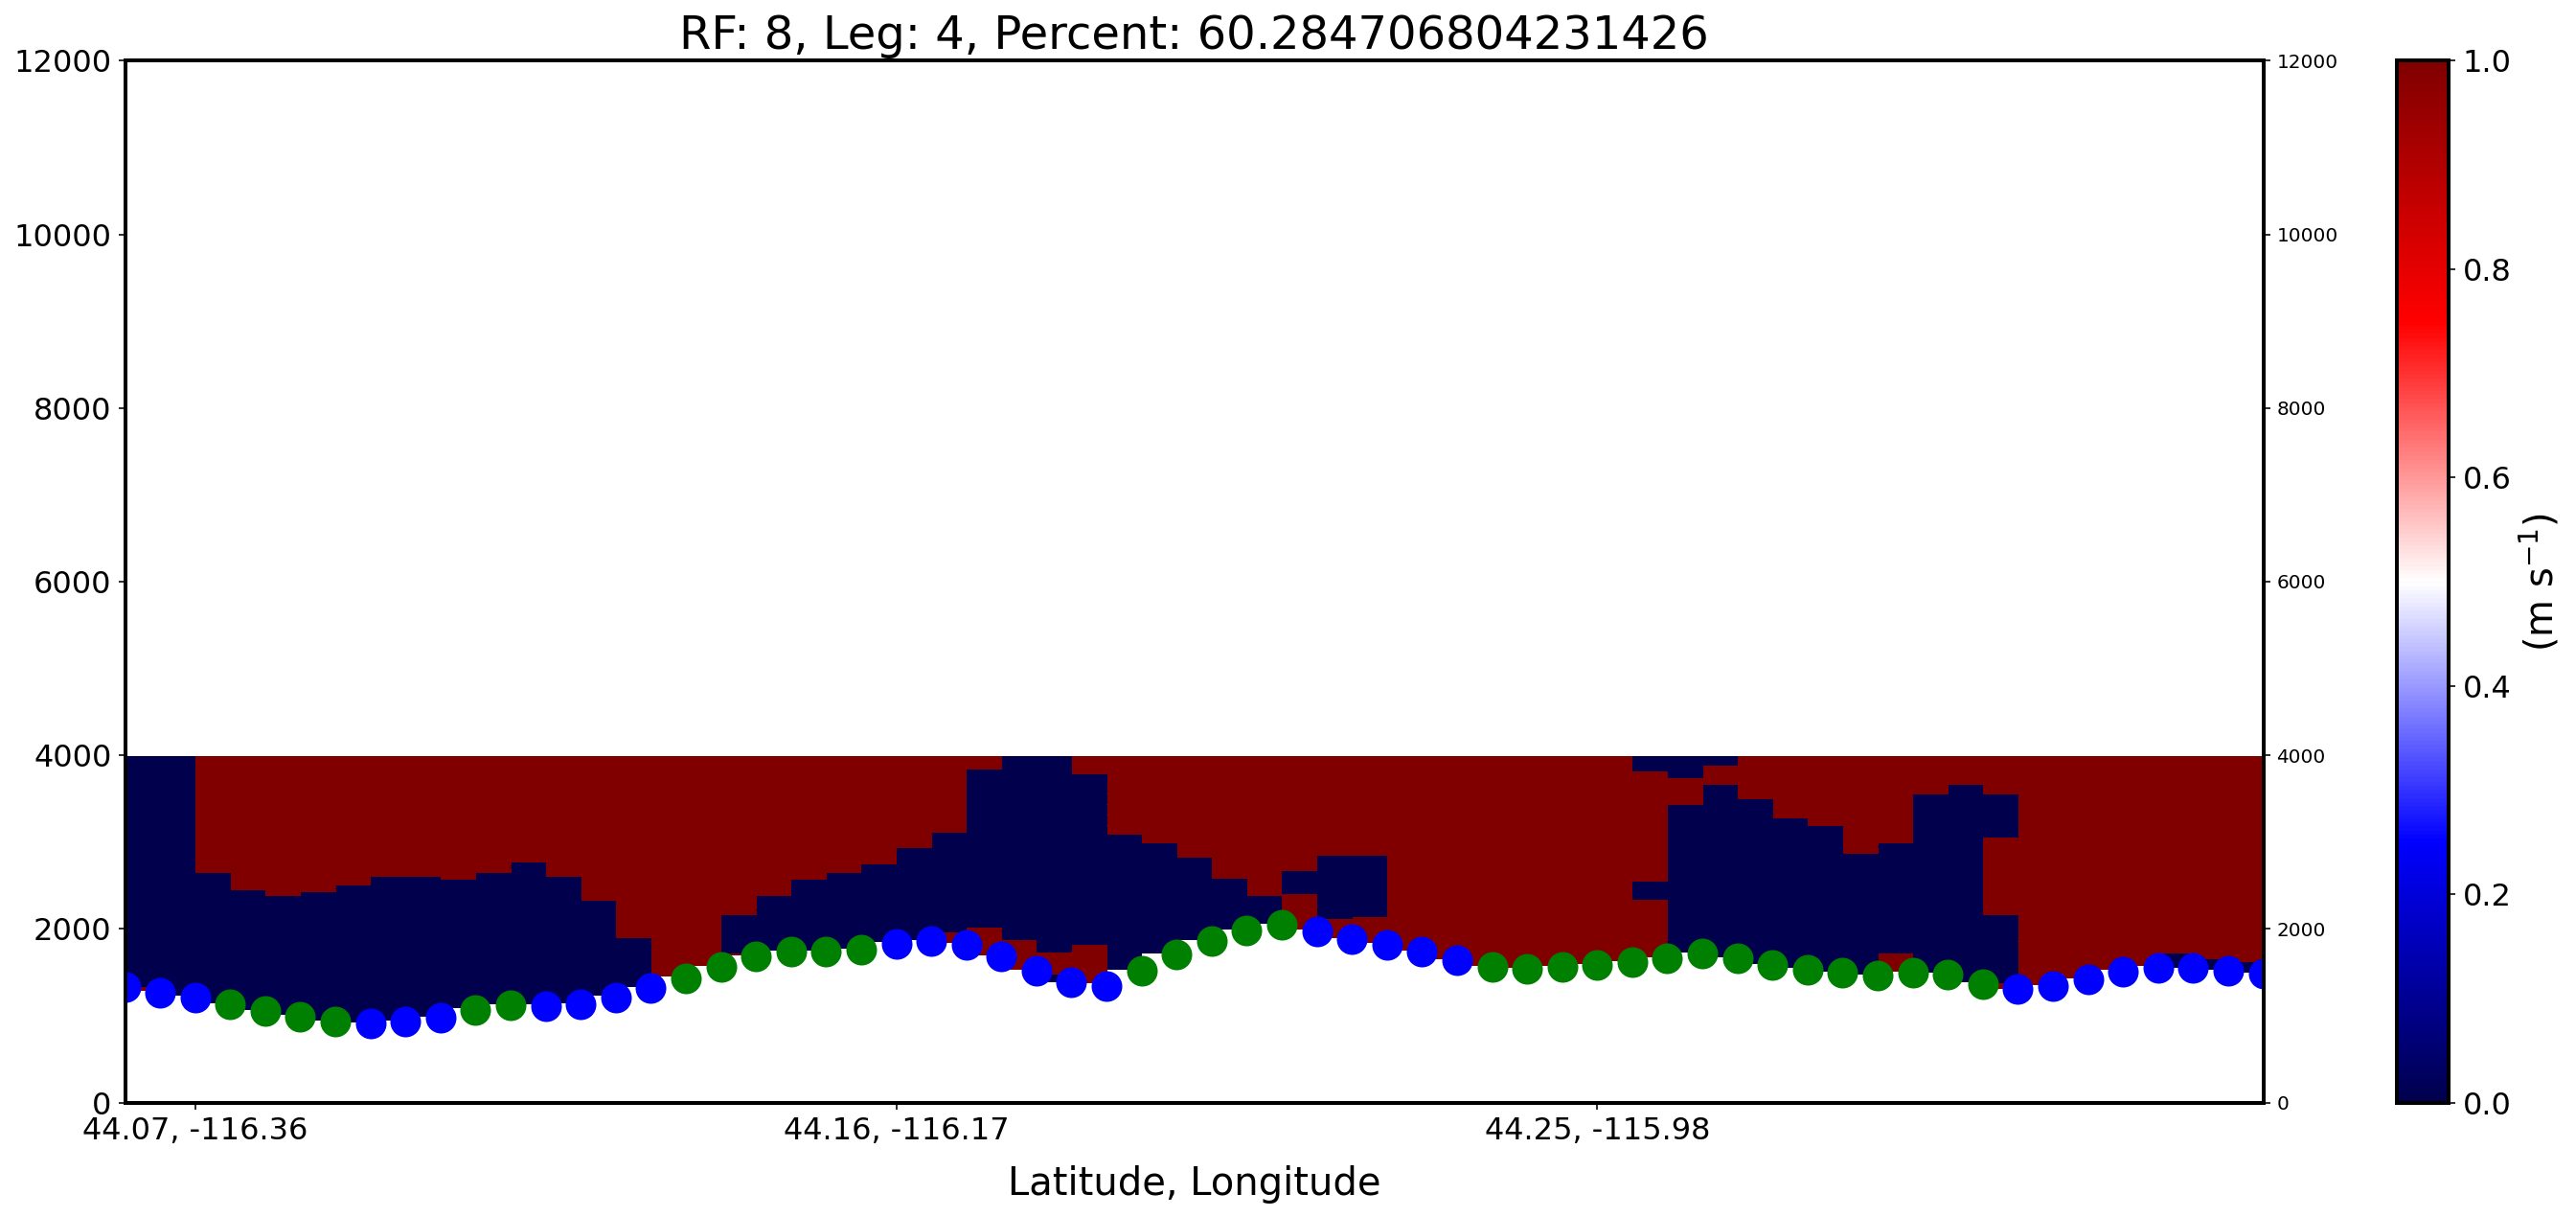

In [21]:
#setting up plot
fig, ax = plt.subplots(figsize = (25, 10))

#plotting w
if iop_t[timeidx][3]==0:
    cm = ax.pcolormesh(across.T.iloc[0:w_01.shape[1],1:-1], height.iloc[0:w_01.shape[1],1:-1], w_01.T.values, vmin = 0, vmax = 1, cmap = 'seismic')
if iop_t[timeidx][3]==1:
    cm = ax.pcolormesh(across.T.iloc[0:w_01.shape[1],1:-1], height.iloc[0:w_01.shape[1],1:-1], w_01[::-1].T.values, vmin = 0, vmax = 1, cmap = 'seismic')


#axis settings
ax.set_ylim(0, 12000)
coord_pairs = to_np(z_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}") for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])

#labels
ax.set_xticklabels(x_labels[::20], rotation=0)
ax.set_xlabel("Latitude, Longitude", fontsize=20, labelpad = 10)

#setting colorbar
cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)
ax.tick_params(which='both',labelsize=16)
    
ax2=ax.twinx()
ax2.set_ylim(0,12000)
for n in range(terr_cross[1:-1].shape[0]):
    if terr_diff.iloc[n].values[0]==1:
        #if iop_t[timeidx][3]==0:
        ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[1:-1].values[n], 'go', markersize=15)
        #if iop_t[timeidx][3]==1:
            #ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[::-1].iloc[1:-1].values[n], 'go', markersize=15)

    if terr_diff.iloc[n].values[0]==0:
        #if iop_t[timeidx][3]==0:
        ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[1:-1].values[n], 'bo', markersize=15)
        #if iop_t[timeidx][3]==1:
            #ax2.plot(np.asarray(across.T.iloc[0:w_01.shape[1],1:-1])[0,n], pd.DataFrame(terr_cross).iloc[::-1].iloc[1:-1].values[n], 'bo', markersize=15)

        
if iop_t[timeidx][3]==1:
    ax.invert_xaxis()



#ax2.set_xlim(min(wrf_distance), max(wrf_distance))
#test=ax2.plot(xcoord,ycoord, color='black')
plt.title('RF: {}, Leg: {}, Percent: {}'.format(rf2, leg, total_percent), fontsize=24)
#plt.savefig('/glade/u/home/kaylee/Quantifying_OF_T/Plots/RF{}_Leg{}_up_down_WRF.pdf'.format(rf2,leg), format='pdf')

In [21]:
initial=pd.read_csv('/glade/u/home/kaylee/Quantifying_OF_T/Files/percent_OF_T_WRF.csv')
initial

,Unnamed: 0,RF,Leg,Match,Total,Percent
0,0,1,8,7674,12045,63.71108343711085
1,1,1,6,7554,12441,60.71859175307451
2,2,1,6,7554,12441,60.71859175307451
3,3,1,9,7395,11644,63.509103400893146
4,4,1,7,7338,11209,65.4652511374788
...,...,...,...,...,...,...
69,69,21,7,7058,10872,64.91905813097866
70,70,21,9,6503,10874,59.80320029427993
71,71,21,3,7641,11578,65.99585420625324
72,72,21,7,7058,10872,64.91905813097866


In [447]:
initial=initial[['RF','Leg', 'Match','Total','Percent']]
initial

,RF,Leg,Match,Total,Percent
0,1,8,7674,12045,63.71108343711085
1,1,6,7554,12441,60.71859175307451
2,1,6,7554,12441,60.71859175307451
3,1,9,7395,11644,63.509103400893146
4,1,7,7338,11209,65.4652511374788
...,...,...,...,...,...
68,21,11,5154,8900,57.91011235955056
69,21,7,7058,10872,64.91905813097866
70,21,9,6503,10874,59.80320029427993
71,21,3,7641,11578,65.99585420625324


In [448]:
data=[{'RF': str(rf2), 'Leg': str(leg), 'Match': str(total_matches), 'Total':str(total_pt),'Percent': str(total_percent)}]
#data=[{'RF': str(16), 'Leg': str(3), 'Match': str('TBD'), 'Total':str('TBD'),'Percent': str('TBD')}]

In [449]:
export=initial.append(data, ignore_index=True)
export

,RF,Leg,Match,Total,Percent
0,1,8,7674,12045,63.71108343711085
1,1,6,7554,12441,60.71859175307451
2,1,6,7554,12441,60.71859175307451
3,1,9,7395,11644,63.509103400893146
4,1,7,7338,11209,65.4652511374788
...,...,...,...,...,...
69,21,7,7058,10872,64.91905813097866
70,21,9,6503,10874,59.80320029427993
71,21,3,7641,11578,65.99585420625324
72,21,7,7058,10872,64.91905813097866


In [450]:
export.to_excel('/glade/u/home/kaylee/Quantifying_OF_T/Files/percent_OF_T_WRF.xlsx')
export.to_csv('/glade/u/home/kaylee/Quantifying_OF_T/Files/percent_OF_T_WRF.csv')

In [18]:
import csv
df=pd.DataFrame(columns=["RF", "Leg", "Match", "Total","Percent"])
df.to_csv('/glade/u/home/kaylee/percent_OF_T_WRF.csv')